In [16]:
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from metpy.plots import USCOUNTIES
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
import numpy as np
from pathlib import Path
from typing import Union

In [18]:
## Defined functions from Tim Supinie's gridradpy repository on GitHub (https://github.com/tsupinie/gridradpy/tree/main) with some modifications ##

_index_variables = ['Reflectivity', 'wReflectivity', 'SpectrumWidth', 'wSpectrumWidth', 'AzShear', 'wAzShear', 
                    'Divergence', 'wDivergence', 'DifferentialReflectivity', 'wDifferentialReflectivity',
                    'DifferentialPhase', 'wDifferentialPhase', 'CorrelationCoefficient', 'wCorrelationCoefficient']


def read_file(infile: Union[str, Path]) -> xr.Dataset:
    ds = xr.open_dataset(infile)

    nlon = ds.dims['Longitude']
    nlat = ds.dims['Latitude']
    nalt = ds.dims['Altitude']

    index = ds['index'].values

    da_dict = {}
    for var in _index_variables:
        if var not in ds.variables:
            continue

        # Create arrays to store binned values for reflectivity at horizontal polarization
        values    = np.zeros(nlon * nlat * nalt, dtype=np.float32)
        values[:] = np.nan

        # Add values to arrays
        values[index[:]]  =  ds[var].values[:]
        da = xr.DataArray(data=values.reshape((nalt, nlat, nlon)), coords=ds['Nradobs'].coords, 
                          dims=ds['Nradobs'].dims, name=ds[var].name, attrs=ds[var].attrs)

        da_dict[var] = da

    ds = ds.assign(**da_dict)

    return ds.drop_vars('index')

def plot_image(ds: xr.Dataset, fname='gridrad_image.png') -> None:
    
    r = [ 49, 30, 15,150, 78, 15,255,217,255,198,255,109,255,255,255]		# RGB color values
    g = [239,141, 56,220,186, 97,222,164,107, 59,  0,  0,  0,171,255]
    b = [237,192,151,150, 25,  3,  0,  0,  0,  0,  0,  0,255,255,255]

    hex_colors = [f'#{r_:02x}{g_:02x}{b_:02x}' for r_, g_, b_ in zip(r, g, b)]
    cmap = mpl.colors.ListedColormap(hex_colors, 'refl')
        
    refl_max = ds['Reflectivity'].max(dim='Altitude')						# Column-maximum reflectivity
    lons = ds['Longitude']
    lats = ds['Latitude']

    fig, ax = plt.subplots(figsize=(10, 6),subplot_kw={'projection': ccrs.PlateCarree()})
    plt.subplot(111)
    ax.set_extent([-95, -80, 40, 50])
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.add_feature(USCOUNTIES.with_scale('5m'), linewidth=0.25)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    plt.pcolormesh(lons, lats, refl_max, cmap=cmap, vmin=0, vmax=75)
    plt.colorbar(shrink=0.85, label='dBZ')
    plt.title('Reflectivity {}z'.format(ds['time'].dt.strftime('%Y-%m-%d %H:%M:%S').values[0]))
    plt.show()

In [4]:
data = 'c:\\Users\\Tony\\Downloads\\nexrad_3d_v4_2_20190720T030000Z.nc'

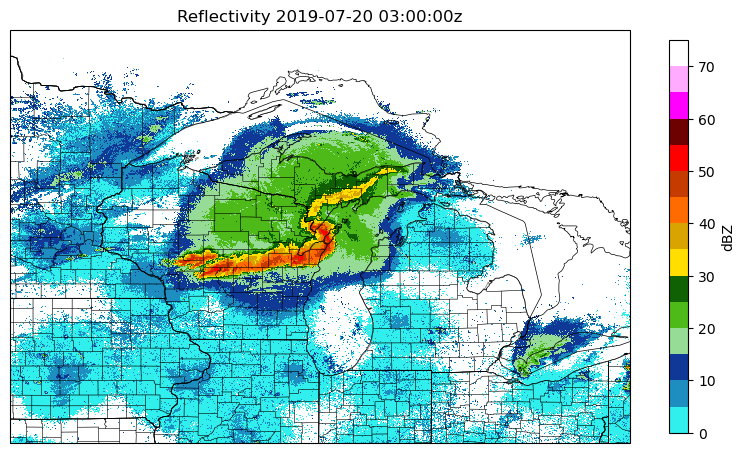

In [19]:
ds = read_file(data)
plot = plot_image(ds, 'gridrad_image_xr.png')